In [1]:
import os
import re
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import json
import PIL
import google.generativeai as genai
import rerun as rr
from faster_whisper import WhisperModel
import sounddevice as sd
import numpy as np
import os
from pydub import AudioSegment
import io

In [3]:
from lerobot.common.policies.act.modeling_act import ACTPolicy
from lerobot.common.policies.pi0.modeling_pi0 import PI0Policy
from lerobot.common.policies.pi0fast.modeling_pi0fast import PI0FASTPolicy
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig
from lerobot.common.robot_devices.robots.utils import make_robot_from_config
from lerobot.common.robot_devices.control_utils import busy_wait, log_control_info
from lerobot.common.robot_devices.robots.configs import So100RobotConfig
#from scripts.image_utils import reorder_tensor_dimensions, tensor_to_pil, display_images
from lerobot.common.vision_utils.gemini_perception import tensor_to_pil, get_2D_bbox, parse_json, normalize_bbox_0to1, plot_bbox, get_target_bbox, get_random_targets, create_pick_place_lists

In [3]:
import os
from google import genai
from google.genai import types
from PIL import Image, ImageDraw
import torch
import numpy as np
import json
import time

GEMINI_API_KEY = os.environ.get("GOOGLE_API_KEY")
client = genai.Client(api_key=GEMINI_API_KEY)
MODEL_ID = "gemini-2.0-flash"  # Use Gemini 2.0 Flash for 3D capabilities
PRO_MODEL_ID ='gemini-2.0-pro-exp-02-05'


In [4]:
def get_2Dbbox_grasp(img, prompt=None) -> str:
    """Prompts Gemini 2.0 Flash 2D bounding box."""
    bounding_box_system_instructions = """
    You are an expert at analyzing images to identify and locate objects.
    Return bounding boxes as a JSON array. Each object in the array should have:
    1. "label" (string): The name of the object
    2. "box_2d" (array of 4 numbers): The bounding box coordinates [ymin, xmin, ymax, xmax], normalized to a 0-1000 scale
    3. "grasp_point" (array of 2 numbers): Top-down grasp points represented as [y, x] coordinates within the bounding box, normalized to a 0-1000 scale
    4. "grasp_angle" (integer): Rotation angle of the gripper in integer degrees between -90 and 90, where 0 means the gripper fingers are aligned with the vertical image axis
    
    Never return Python code fencing (```python ... ```) or general markdown fencing (``` ... ```) around the JSON. Only output the raw JSON array.
    If an object is present multiple times, name them uniquely (e.g., "red lego brick 1", "red lego brick 2").
    The grasp point should be a good location to grasp the object, typically at its center or an appropriate gripping location.
    """

    if prompt is None:
        prompt = """Analyze the provided image. Detect all distinct lego bricks, small toys, and any items that could be considered a 'blue bin' or a 'yellow bin' present on the desk.
        Ignore the robot arm itself if visible.
        
        Find the grasp points and grasp angles on each object. Top-down grasp points are represented as y, x coordinates, and a rotation angle θ. 
        The rotation angle is represented in integer degrees between -90 and 90, and 0 is where the gripper fingers are aligned with the vertical image axis.
        
        Return your findings strictly as a JSON array, following the format specified in the system instructions.
        Example of the expected JSON output format: 
        [
            {"label": "blue lego brick", "box_2d": [100, 200, 150, 280], "grasp_point": [125, 240], "grasp_angle": 45}, 
            {"label": "yellow bin", "box_2d": [500, 600, 700, 850], "grasp_point": [600, 725], "grasp_angle": 0}
        ]"""
    
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[img, prompt],
        config=types.GenerateContentConfig(system_instruction=bounding_box_system_instructions, temperature=0.5),
    )
    return response.text

def get_3d_bbox(img, prompt=None) -> str:
# Analyze the image using Gemini
    if prompt is None:
        prompt = """
          Detect the 3D bounding boxes of no more than 10 items.
          Output a json list where each entry contains the object name in "label" and its 3D bounding box in "box_3d"
          The 3D bounding box format should be [x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw].
        """
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[
            img,
            prompt
        ],
        config = types.GenerateContentConfig(
            temperature=0.5
        )
    )
    return response.text

def plot_bbox_grasp(im_tensor, bbox, grasp_point=None, grasp_angle=0, label=None):
    """
    Plots bounding boxes, grasp points, grasp angles, and labels on an image.

    Args:
        im_tensor: The image tensor
        bbox: Bounding box in normalized [y1, x1, y2, x2] format with values 0-1000
        grasp_point: Grasp point in normalized [y, x] format with values 0-1000
        grasp_angle: Grasp angle in degrees (-90 to 90)
        label: Text label to display
    """
    # Load the image
    im = tensor_to_pil(im_tensor)
    img = im.copy()
    width, height = img.size
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define colors
    bbox_color = 'red'
    grasp_point_color = 'blue'
    grasp_line_color = 'green'
    text_color = 'white'
    
    # Convert normalized bbox coordinates to absolute coordinates
    abs_y1 = int(bbox[0]/1000 * height)
    abs_x1 = int(bbox[1]/1000 * width)
    abs_y2 = int(bbox[2]/1000 * height)
    abs_x2 = int(bbox[3]/1000 * width)

    if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

    if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

    # Draw the bounding box
    draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=bbox_color, width=4)
    
    # Draw grasp point and angle if provided
    if grasp_point is not None:
        # Default grasp point to center of bounding box if not specified
        if grasp_point == [0, 0] and bbox != [0, 0, 0, 0]:
            grasp_y = (bbox[0] + bbox[2]) / 2
            grasp_x = (bbox[1] + bbox[3]) / 2
        else:
            grasp_y, grasp_x = grasp_point
            
        # Convert to absolute coordinates
        abs_grasp_y = int(grasp_y/1000 * height)
        abs_grasp_x = int(grasp_x/1000 * width)
        
        # Draw grasp point (circle)
        grasp_radius = 5
        draw.ellipse((abs_grasp_x - grasp_radius, abs_grasp_y - grasp_radius, 
                      abs_grasp_x + grasp_radius, abs_grasp_y + grasp_radius), 
                      fill=grasp_point_color)
        
        # Draw gripper orientation line
        line_length = 30
        angle_rad = np.radians(grasp_angle)
        end_x = abs_grasp_x + int(line_length * np.sin(angle_rad))
        end_y = abs_grasp_y - int(line_length * np.cos(angle_rad))
        draw.line((abs_grasp_x, abs_grasp_y, end_x, end_y), fill=grasp_line_color, width=3)
        
        # Draw perpendicular lines for gripper fingers
        perp_length = 15
        perp_angle_rad = angle_rad + np.pi/2
        
        # First finger
        finger1_x = end_x + int(perp_length * np.sin(perp_angle_rad))
        finger1_y = end_y - int(perp_length * np.cos(perp_angle_rad))
        draw.line((end_x, end_y, finger1_x, finger1_y), fill=grasp_line_color, width=3)
        
        # Second finger
        finger2_x = end_x - int(perp_length * np.sin(perp_angle_rad))
        finger2_y = end_y + int(perp_length * np.cos(perp_angle_rad))
        draw.line((end_x, end_y, finger2_x, finger2_y), fill=grasp_line_color, width=3)
    
    # Draw label if provided
    if label:
        # Choose font and font size (you may need to install the font or use an existing one)
        try:
            from PIL import ImageFont
            font = ImageFont.truetype("Arial.ttf", 20)
        except:
            font = None
            
        # Add text background for better visibility
        text_bbox = draw.textbbox((abs_x1, abs_y1 - 25), label, font=font)
        draw.rectangle(text_bbox, fill='black')
        draw.text((abs_x1, abs_y1 - 25), label, fill=text_color, font=font)
        
        # Draw angle text near grasp point if available
        if grasp_point is not None and grasp_angle != 0:
            angle_text = f"{grasp_angle}°"
            draw.text((abs_grasp_x + 10, abs_grasp_y + 10), angle_text, fill=text_color, font=font)

    return img

[Link to Colab for more examples of Spacial 3D understanding with Gemini](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb#scrollTo=WbWHzjtT6ELv)

In [13]:
# Create camera config using proper config objects
cameras = {
    "front": OpenCVCameraConfig(
        camera_index=0,  # Built-in webcam
        fps=30,
        width=640,
        height=480
    ),
#    "top": OpenCVCameraConfig(
#        camera_index=1,  # iPhone camera
#        fps=30,
#        width=640,
#        height=480
#    )
}

robot_cfg = So100RobotConfig(
            cameras=cameras,
            mock=False, 
            
        )
        
        # Create and connect robot
robot = make_robot_from_config(robot_cfg)
robot.connect()

Connecting main follower arm.
Connecting main leader arm.
Activating torque on main follower arm.


In [14]:
observation = robot.capture_observation()
spatial_coords = json.loads(parse_json(get_2Dbbox_grasp(tensor_to_pil(observation["observation.images.front"]))))

In [15]:
img = tensor_to_pil(observation["observation.images.front"])

In [18]:
for i in range(len(spatial_coords)):
    print(spatial_coords[i])

{'label': 'red lego brick', 'box_2d': [435, 69, 504, 164], 'grasp_point': [471, 115], 'grasp_angle': 0}
{'label': 'green lego brick', 'box_2d': [433, 246, 491, 298], 'grasp_point': [456, 268], 'grasp_angle': 0}
{'label': 'white case', 'box_2d': [400, 238, 456, 327], 'grasp_point': [425, 273], 'grasp_angle': 0}
{'label': 'swiss knife', 'box_2d': [518, 90, 643, 155], 'grasp_point': [589, 117], 'grasp_angle': 0}
{'label': 'wooden block 1', 'box_2d': [393, 416, 452, 497], 'grasp_point': [416, 455], 'grasp_angle': 0}
{'label': 'blue bin', 'box_2d': [333, 677, 468, 843], 'grasp_point': [391, 757], 'grasp_angle': 0}
{'label': 'wooden block 2', 'box_2d': [481, 661, 579, 725], 'grasp_point': [520, 690], 'grasp_angle': 0}
{'label': 'yellow toy car', 'box_2d': [520, 751, 716, 850], 'grasp_point': [600, 802], 'grasp_angle': 0}
{'label': 'lego brick 1', 'box_2d': [725, 893, 956, 1000], 'grasp_point': [852, 950], 'grasp_angle': 0}
{'label': 'headphones', 'box_2d': [435, 161, 825, 573], 'grasp_point'

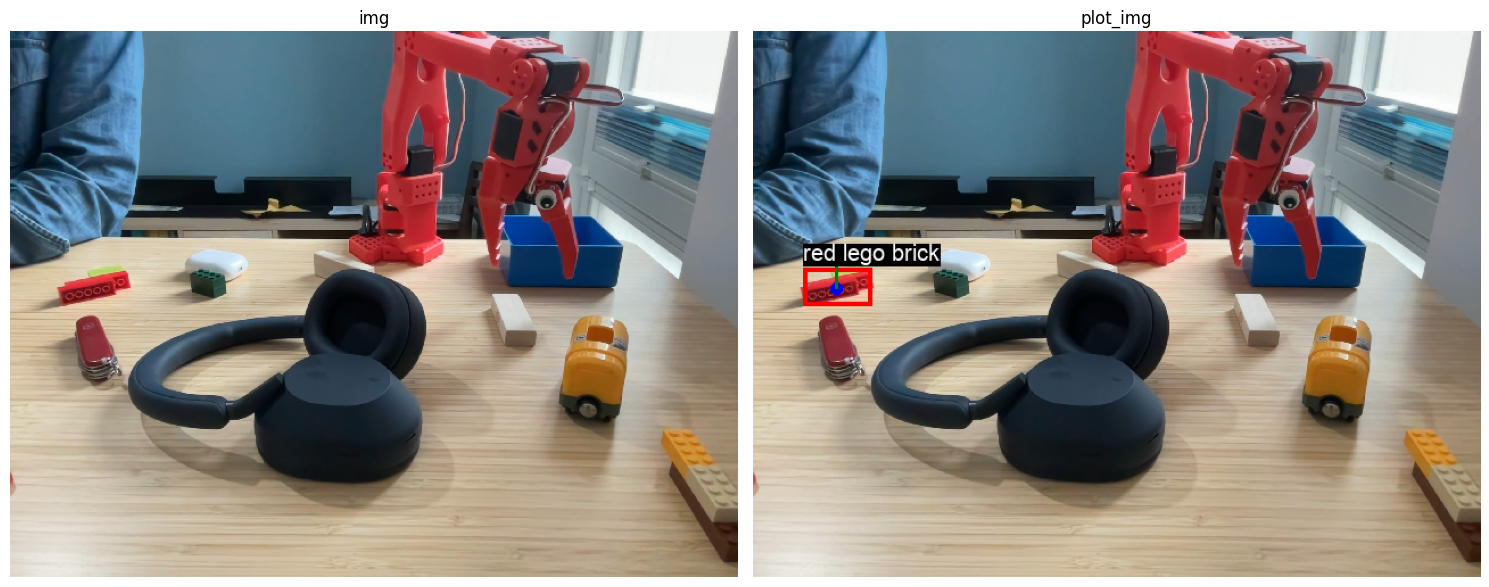

In [21]:
plot_img = plot_bbox_grasp(observation["observation.images.front"], spatial_coords[0]["box_2d"], spatial_coords[0]["grasp_point"], spatial_coords[0]["grasp_angle"], spatial_coords[0]["label"])
display_images(img, plot_img)

In [8]:
robot.disconnect()